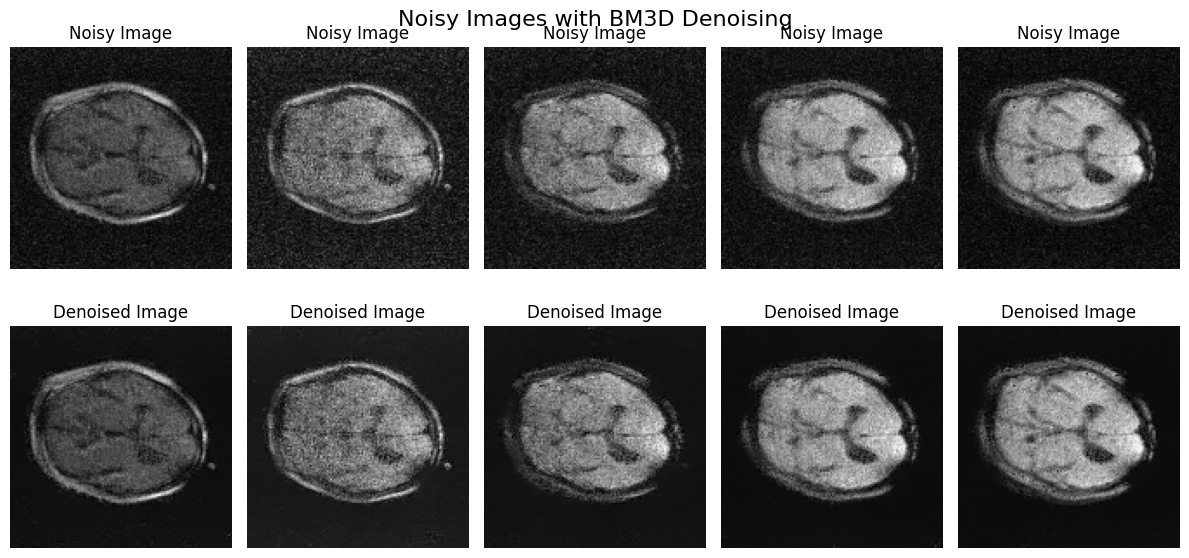

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import estimate_sigma, denoise_nl_means
from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.color import rgb2gray

from skimage.measure import label, regionprops

import scipy.io

def create_background_mask(image_gray):
    # Use Otsu's method to automatically determine a threshold for binarization
    thresh = threshold_otsu(image_gray)

    # Binarize the image based on the determined threshold
    binary_image = image_gray <= thresh

    # Remove small objects and clear borders
    cleared_image = clear_border(binary_image)

    # Label connected components
    label_image = label(cleared_image)

    # Find properties of labeled regions
    regions = regionprops(label_image)

    # Find the largest region (assuming it's the background)
    largest_area = 0
    background_label = 0
    for region in regions:
        if region.area > largest_area:
            largest_area = region.area
            background_label = region.label

    # Create a mask for the background region
    background_mask = label_image == background_label

    return background_mask

def adjust_denoising_parameters(sigma_est):
    if sigma_est <= 15:
        return 0.6 * sigma_est, 7, 11  # h, patch_size, patch_distance
    elif sigma_est <= 30:
        return 0.9 * sigma_est, 5, 6
    elif sigma_est <= 50:
        return 0.2 * sigma_est, 9, 17
    else:
        return 0.4 * sigma_est, 11, 23

def denoise_image(noisy_image_gray):
    # Estimate the noise standard deviation from the image
    sigma_est = np.mean(estimate_sigma(noisy_image_gray))

    # Dynamically adjust denoising parameters based on estimated noise level
    h, patch_size, patch_distance = adjust_denoising_parameters(sigma_est)

    # Create a mask to isolate the background
    background_mask = create_background_mask(noisy_image_gray)

    # Apply Non-Local Means Denoising with dynamically adjusted parameters
    denoised_image = denoise_nl_means(noisy_image_gray, h=h, patch_size=patch_size,
                                      patch_distance=patch_distance)

    return denoised_image

def main():
    # Load noisy image data from the mat file
    mat = scipy.io.loadmat('../TraditionalMethods/medicaldata.mat')
    noisy_image_data = mat['data']

    # Plot the noisy and denoised images
    conditions = noisy_image_data.shape[2]
    plt.figure(figsize=(12, 6))
    for j in range(conditions):
        noisy_image = noisy_image_data[:, :, j]

        # Convert to grayscale if it's a multichannel image
        if noisy_image.ndim == 3 and noisy_image.shape[2] == 3:
            noisy_image_gray = rgb2gray(noisy_image)
        else:
            noisy_image_gray = noisy_image

        # Denoise the image
        denoised_image = denoise_image(noisy_image_gray)

        plt.subplot(2, conditions, j + 1)
        plt.imshow(noisy_image_gray, cmap='gray')
        plt.title('Noisy Image')
        plt.axis('off')

        plt.subplot(2, conditions, j + conditions + 1)
        plt.imshow(denoised_image, cmap='gray')
        plt.title(f'Denoised Image')
        plt.axis('off')
         
        # Save denoised image to file
        plt.imsave(f'denoised_image_NLM{j + 1}.png', denoised_image, cmap='gray')

    plt.tight_layout()
    plt.suptitle('Noisy Images with NLM Denoising', fontsize=16)
    plt.show()

if __name__ == '__main__':
    main()
